In [76]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from urllib.request import urlopen
from urllib.error import HTTPError
from wordcloud import wordcloud, STOPWORDS
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

In [46]:
def get_noticias(url, keywords):
    """
    Função que coleta notícias de uma página específica baseada em palavras-chave nos links.
    Também coleta a data de publicação, se disponível.
    """
    noticias = []
    response = requests.get(url)
    response.encoding = response.apparent_encoding  # Ajuste para decodificação correta
    soup = BeautifulSoup(response.content, "html.parser")

    # Encontrar todos os links na página
    links = soup.find_all('a', href=True)

    # Filtrar e armazenar apenas os links que contêm as palavras-chave
    for link_tag in links:
        link = link_tag['href']
        title = link_tag.get_text(strip=True)
        
        # Verificar se a palavra-chave está no link ou no título
        if any(keyword in link.lower() for keyword in keywords):
            # Se o link não é absoluto, fazê-lo absoluto
            if not link.startswith('http'):
                link = urljoin(url, link)

            # Tentar capturar a data de publicação da notícia
            try:
                # Exemplos genéricos: ajuste conforme a estrutura do site
                date_tag = soup.find('time')  # Se houver uma tag <time> na página
                if date_tag and date_tag.has_attr('datetime'):
                    date = date_tag['datetime']
                else:
                    # Tentativa alternativa, por exemplo, se a data estiver em um <span> com uma classe específica
                    date_tag = soup.find('span', class_='data-publicacao')
                    date = date_tag.get_text(strip=True) if date_tag else 'Data não disponível'
            except Exception as e:
                date = 'Data não disponível'

            # Adicionar a notícia à lista, incluindo a data
            if title:
                noticias.append({"title": title, "link": link, "date": date})
    
    return noticias

def crawl_site(url, base_url, keywords, depth=3):
    """
    Função recursiva para percorrer todo o site, coletando notícias relevantes.
    Agora coleta a data da notícia.
    """
    visited_links = set()
    noticias = []

    def _crawl(url, current_depth):
        # Verificar se o link já foi visitado ou se a profundidade máxima foi atingida
        if current_depth == 0 or url in visited_links:
            return
        
        visited_links.add(url)  # Marcar o link como visitado
        noticias_atual = get_noticias(url, keywords)

        # Remover links duplicados antes de adicionar à lista de notícias
        for noticia in noticias_atual:
            if noticia["link"] not in {n["link"] for n in noticias}:
                noticias.append(noticia)

        response = requests.get(url)
        response.encoding = response.apparent_encoding
        soup = BeautifulSoup(response.content, "html.parser")

        # Encontrar todos os links na página e seguir
        links = soup.find_all('a', href=True)

        for link_tag in links:
            link = link_tag['href']
            if not link.startswith('http'):
                link = urljoin(base_url, link)

            # Verificar se o link é interno e não foi visitado
            if base_url in link and link not in visited_links:
                _crawl(link, current_depth - 1)

    _crawl(url, depth)
    return noticias

def get_text(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features='html.parser')

    for script in soup(['script', 'style']):
        script.extract()

    text = soup.get_text()

    lines = (line.strip() for line in text.splitlines())

    chunks = (phrase.strip() for line in lines for phrase in line.split(" "))

    text = ' '.join(chunk for chunk in chunks if chunk)

    return text
    
    #return text.encode('utf-8', errors='ignore').decode('utf-8')

def coluna_texto(df):
    df['corpo_texto'] = df['link'].apply(get_text)
    

def plot_keyword_distribution(df, keyword, color):
    filtered_df = df[df['title'].str.contains(keyword, case=False, na=False)]
    site_counts = filtered_df['Site'].value_counts()

    plt.figure(figsize=(10, 6))
    site_counts.plot(kind='bar', color=color)
    plt.title(f'Número de Links por Site Contendo "{keyword}"')
    plt.xlabel('Site')
    plt.ylabel('Número de Links')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [47]:
base_url = "https://www1.folha.uol.com.br/equilibrioesaude/"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias do site inteiro, seguindo links internos
noticias_folha = crawl_site(base_url, base_url, keywords, depth=3)

# Converter a lista de notícias em um DataFrame do pandas
df_folha = pd.DataFrame(noticias_folha)

# Remover títulos duplicados
df_folha = df_folha.drop_duplicates(subset='title')

df_folha['Site'] = 'Folha'

# Adicionar a coluna 'full_text' com o texto completo extraído de cada link
coluna_texto(df_folha)

# Exibir o DataFrame filtrado
df_folha

,title,link,date,Site,corpo_texto
0,Pesquisadores da UFMG estudam desenvolvimento ...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Brasil já estuda desenvolvimento de uma vacina...
1,Tire dúvidas sobre a vacinação de crianças con...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Tire suas dúvidas sobre a vacinação de criança...
2,Pais que não vacinam filhos podem até perder a...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Pais que não vacinam filhos podem ser multados...
3,"CGU aplica multa de R$ 17,7 mi a laboratório i...",https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,CGU multa Bharat Biotech por fraude na vacina ...
4,Rio amplia vacina da Covid adaptada contra nov...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Covid: Rio amplia vacinação contra XBB para to...
...,...,...,...,...,...
113,lockdown é eficaz para a diminuição de casos d...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-09 19:38:00,Folha,Estudo demonstra que lockdown é eficaz para co...
114,pandemia,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-09 19:38:00,Folha,Covid: pandemia foi marcada por erros e mortes...
115,não apresentam nenhum risco à saúde,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-09 19:38:00,Folha,Covid: entenda os riscos da vacina da AstraZen...
116,retirada do mercado seguiu questões comerciais,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-09 19:38:00,Folha,AstraZeneca para de fabricar e distribuir vaci...


In [48]:
base_url1 = 'https://g1.globo.com/fato-ou-fake/'

noticias_g1 = crawl_site(base_url1, base_url1, keywords, depth=3)

df_g1 = pd.DataFrame(noticias_g1)

df_g1['Site'] = 'Fato ou fake (G1)'

coluna_texto(df_g1)

df_g1

,title,link,date,Site,corpo_texto
0,É #FAKE que médicos mortos em queda de avião e...,https://g1.globo.com/fato-ou-fake/campinas-e-r...,Data não disponível,Fato ou fake (G1),É #FAKE que médicos mortos em queda de avião e...
1,É #FAKE que o Brasil é o único país a exigir v...,https://g1.globo.com/fato-ou-fake/noticia/2024...,Data não disponível,Fato ou fake (G1),É #FAKE que o Brasil é o único país a exigir v...


In [52]:
base_url2 = 'https://www.gov.br/saude/pt-br'

noticias_gov = crawl_site(base_url2, base_url2, keywords, depth=3)

df_gov = pd.DataFrame(noticias_gov)

df_gov['Site'] = 'gov.br saude'

def get_text2(url):
    try:
        response = requests.get(url, timeout=10)  # Adicionar timeout
        response.encoding = response.apparent_encoding  # Ajustar para a codificação correta
        soup = BeautifulSoup(response.content, features='html.parser')

        for script in soup(['script', 'style']):
            script.extract()

        text = soup.get_text()
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split(" "))
        text = ' '.join(chunk for chunk in chunks if chunk)

        # Adaptar para UTF-8, ignorando erros de codificação
        return text.encode('utf-8', errors='ignore').decode('utf-8')
    
    except (HTTPError, requests.exceptions.RequestException) as e:
        print(f"Erro ao acessar {url}: {e}")
        return "Erro ao carregar o texto"

def coluna_texto(df):
    df['corpo_texto'] = df['link'].apply(get_text2)

coluna_texto(df_gov)

df_gov


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Erro ao acessar https://www.gov.br/saude/pt-br/assuntos/noticias/2023/dezembro/brasil-reverte-tendencia-de-queda-nas-coberturas-vacinais-e-oito-imunizantes-do-calendario-infantil-registram-alta-em-2023: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/distribuicao-de-imunobiologicos/situacao-da-distribuicao-de-imunobiologicos-aos-estados-para-a-rotina-do-mes-de-jan-2022: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/distribuicao-de-imunobiologicos/2022-situacao-da-distribuicao-de-imunobiologicos-aos-estados-para-a-rotina-do-mes-de-mar-2022: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/distribuicao-de-imunobiologicos/situacao-da-distribuicao-de-imunobiologicos-aos-estados-para-a-rotina-do-mes-de-jun-2022: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/distribuicao-de-imunobiologicos/situacao-da-distribuicao-de-imunobiologicos-aos-estados-para-a-rotina-do-mes-de-jul-2022: HTTPSConnectionPool(host='w

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/informes-tecnicos/informe-tecnico-operacional-de-vacinacao-contra-a-mpox: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/informes-tecnicos/informe-tecnico-operacional-de-vacinacao-contra-a-covid-19: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

Erro ao acessar https://registra-rh-covid19.saude.gov.br/: HTTPSConnectionPool(host='registra-rh-covid19.saude.gov.br', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x74228ec57160>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Erro ao acessar https:// https//antigo.saude.gov.br/images/pdf/2020/marco/04/Calendario-Vacinao-2020-Crian--a.pdf: HTTPSConnectionPool(host='%20https', port=443): Max retries exceeded with url: //antigo.saude.gov.br/images/pdf/2020/marco/04/Calendario-Vacinao-2020-Crian--a.pdf (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x74228ec57160>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Erro ao acessar http://%20https//www.gov.br/saude/pt-br/coronavirus/vacinas/plano-nacional-de-operacionalizacao-da-vacina-contra-a-covid-19: HTTPConnectionPool(host='%20https', port=80): Max retries exceeded with u

,title,link,date,Site,corpo_texto
0,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,gov.br saude,Covid-19 — Ministério da Saúde Ir para o Conte...
1,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,gov.br saude,Vacinação — Ministério da Saúde Ir para o Cont...
2,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,Calendário de Vacinação — Ministério da Saúde ...
3,Calendário Técnico Nacional de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,Calendário Técnico Nacional de Vacinação — Min...
4,Atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,gov.br saude,Atividades de vacinação de alta qualidade (Ava...
...,...,...,...,...,...
343,Raíssa Machado,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude,Raissa Machado — Ministério da Saúde Ir para o...
344,Margareth Dalcolmo,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude,Margareth Dalcolmo — Ministério da Saúde Ir pa...
345,Acesse as Peças do Movimento Nacional pela Va...,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude,Movimento Nacional pela Vacinação — Ministério...
346,Acesse para saber como emitir o Certificado Na...,https://www.gov.br/pt-br/servicos/certificado-...,Data não disponível,gov.br saude,Obter o Certificado Nacional de Vacinação COVI...


In [53]:
base_url3 = 'https://www.aosfatos.org'

noticias_aosfatos = crawl_site(base_url3, base_url3, keywords, depth=3)

df_aosfatos = pd.DataFrame(noticias_aosfatos)

df_aosfatos['Site'] = 'Aos Fatos'

coluna_texto(df_aosfatos)

df_aosfatos

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Erro ao acessar https://www.covid19treatmentguidelines.nih.gov/therapies/miscellaneous-drugs/ivermectin/: HTTPSConnectionPool(host='www.covid19treatmentguidelines.nih.gov', port=443): Max retries exceeded with url: /therapies/miscellaneous-drugs/ivermectin/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x74228df5bc10>: Failed to establish a new connection: [Errno -2] Name or service not known'))


,title,link,date,Site,corpo_texto
0,Para que serve e quem pode tomar a vacina cont...,https://www.aosfatos.org/noticias/para-que-ser...,Data não disponível,Aos Fatos,Para que serve e quem pode tomar a vacina cont...
1,entrou com uma ação,https://www.aosfatos.org/bipe/agu-acao-telegra...,Data não disponível,Aos Fatos,AGU aciona Telegram na Justiça após Aos Fatos ...
2,nesta quinta-feira (25),https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,Aos Fatos,Ministério da Saúde anuncia estratégia de vaci...
3,5 milhões em 2024,https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,Aos Fatos,Ministério da Saúde incorpora vacina contra a ...
4,lista de municípios,https://www.gov.br/saude/pt-br/assuntos/saude-...,Data não disponível,Aos Fatos,Regiões de Saúde Atendidas em 2024 — Ministéri...
5,Folha de S.Paulo,https://www1.folha.uol.com.br/equilibrioesaude...,Data não disponível,Aos Fatos,Vacina da dengue: saiba como se vacinar na red...
6,primeira vacina a ser aprovada no Brasil,https://www.gov.br/anvisa/pt-br/assuntos/fisca...,Data não disponível,Aos Fatos,%PDF-1.6 %���� 105 0 obj <> endobj 126 0 obj <...
7,65% de eficácia,https://familia.sbim.org.br/vacinas/vacinas-di...,Data não disponível,Aos Fatos,Vacinas dengue - Família SBIm Toggle search Tw...
8,28 mil crianças e adultos,https://www.takeda.com/pt-br/Newsroom/releases...,Data não disponível,Aos Fatos,Page 404 EN AboutOur CompanyLeadershipCorporat...
9,fez uma parceria,https://www1.folha.uol.com.br/equilibrioesaude...,Data não disponível,Aos Fatos,Vacina da dengue: Dourados é a 1ª cidade a dar...


In [54]:
base_url4 = 'https://g1.globo.com/saude/'

noticias_g1saude = crawl_site(base_url4, base_url4, keywords, depth=3)

df_g1saude = pd.DataFrame(noticias_g1saude)

df_g1saude['Site'] = 'G1 - Saúde'

coluna_texto(df_g1saude)

df_g1saude

,title,link,date,Site,corpo_texto
0,Fabricante de vacina contra mpox quer ampliar ...,https://g1.globo.com/saude/noticia/2024/08/16/...,Data não disponível,G1 - Saúde,Fabricante de vacina contra mpox quer ampliar ...
1,como também aconteceu com a Covid,https://g1.globo.com/saude/noticia/2023/05/05/...,2024-08-14T17:25:09.592Z,G1 - Saúde,Covid não é mais uma emergência sanitária de i...
2,"Após afetar Tóquio, atletas testam positivo pa...",https://g1.globo.com/mundo/olimpiadas/paris-20...,Data não disponível,G1 - Saúde,"Após afetar Tóquio, atletas testam positivo pa..."
3,O que muda na campanha de vacinação contra cov...,https://g1.globo.com/saude/noticia/2024/06/01/...,Data não disponível,G1 - Saúde,O que muda na campanha de vacinação contra cov...
4,Covid-19: por que descoberta de danos às 'usin...,https://g1.globo.com/sp/campinas-regiao/notici...,Data não disponível,G1 - Saúde,Covid-19: por que descoberta de danos às 'usin...
5,Memorial em homenagem às vítimas da Covid-19 é...,https://g1.globo.com/mg/triangulo-mineiro/noti...,Data não disponível,G1 - Saúde,Memorial em homenagem às vítimas da Covid-19 é...
6,Covid: Vacinação passa a ser anual para crianç...,https://g1.globo.com/saude/coronavirus/vacinas...,Data não disponível,G1 - Saúde,Covid: Vacinação passa a ser anual para crianç...
7,Covid longa pode causar danos a órgãos importa...,https://g1.globo.com/saude/noticia/2023/09/23/...,Data não disponível,G1 - Saúde,Covid longa pode causar danos a órgãos importa...
8,Brasil tem alta da Covid em onda que deve dura...,https://g1.globo.com/saude/noticia/2023/08/31/...,Data não disponível,G1 - Saúde,Brasil tem alta da Covid em onda que deve dura...
9,Covid: variante Éris é confirmada pela 1ª vez ...,https://g1.globo.com/saude/coronavirus/noticia...,Data não disponível,G1 - Saúde,Covid: variante Éris é confirmada pela 1ª vez ...


In [55]:
base_url5 = 'https://www.saude.gov.br/fakenews'

noticias_govfake = crawl_site(base_url5, base_url5, keywords, depth=3)

df_govfake = pd.DataFrame(noticias_govfake)

df_govfake['Site'] = 'Gov - Fake'

coluna_texto(df_govfake)

df_govfake

Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/distribuicao-de-imunobiologicos: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)


,title,link,date,Site,corpo_texto
0,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,Gov - Fake,Covid-19 — Ministério da Saúde Ir para o Conte...
1,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,Gov - Fake,Vacinação — Ministério da Saúde Ir para o Cont...
2,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,Gov - Fake,Calendário de Vacinação — Ministério da Saúde ...
3,Calendário Técnico Nacional de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,Gov - Fake,Calendário Técnico Nacional de Vacinação — Min...
4,Atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,Gov - Fake,Atividades de vacinação de alta qualidade (Ava...
5,Distribuição de Imunobiológicos,https://www.gov.br/saude/pt-br/vacinacao/distr...,Data não disponível,Gov - Fake,Erro ao carregar o texto
6,Segurança das Vacinas,https://www.gov.br/saude/pt-br/vacinacao/esavi,Data não disponível,Gov - Fake,Eventos Supostamente Atribuíveis à Vacinação o...
7,Vacinas para Grupos Especiais,https://www.gov.br/saude/pt-br/vacinacao/grupo...,Data não disponível,Gov - Fake,Vacinas para grupos especiais — Ministério da ...
8,Vacinação para os Viajantes,https://www.gov.br/saude/pt-br/vacinacao/viaja...,Data não disponível,Gov - Fake,Vacinação para os Viajantes — Ministério da Sa...
9,Rede de Frio,https://www.gov.br/saude/pt-br/vacinacao/rede-...,Data não disponível,Gov - Fake,Rede de Frio — Ministério da Saúde Ir para o C...


In [56]:
base_url6 = 'https://www.boatos.org'

noticias_boatos = crawl_site(base_url6, base_url6, keywords, depth=3)

df_boatos = pd.DataFrame(noticias_boatos)

df_boatos['Site'] = 'boatos.org'

coluna_texto(df_boatos)

df_boatos

,title,link,date,Site,corpo_texto
0,Fake news sobre nanobots em vacinas contra Cov...,https://www.boatos.org/saude/nanobots-foram-en...,2024-08-19T13:50:07-03:00,boatos.org,Nanobots foram encontrados em milhões de pesso...
1,É falso que Brasil seja o único país do mundo ...,https://www.boatos.org/saude/brasil-e-o-unico-...,2024-08-16T18:38:39-03:00,boatos.org,Brasil é o único país a exigir vacina contra C...
2,A teoria maluca de que médicos foram assassina...,https://www.boatos.org/mundo/andreas-noack-ass...,2024-08-13T16:25:03-03:00,boatos.org,Andreas Noack foi assassinado por descobrir gr...
3,aqui,https://www.boatos.org/saude/japoneses-nanopar...,2024-08-12T13:42:25-03:00,boatos.org,Japoneses descobrem que nanopartículas mRNA da...
4,aqui,https://www.boatos.org/saude/ministro-e-lider-...,2024-08-12T13:42:25-03:00,boatos.org,Ministro e líder do Japão pediu desculpas a nã...
5,WhatsApp,https://www.boatos.org/saude/nanobots-foram-en...,2024-08-12T13:42:25-03:00,boatos.org,Compartilhe no WhatsApp Pular para o conteúdoP...
6,Telegram,https://www.boatos.org/saude/nanobots-foram-en...,2024-08-12T13:42:25-03:00,boatos.org,Telegram: Share Web Page Download https://www....
7,Fake news: Dr. Charles Hoffe está certo ao diz...,https://www.boatos.org/fast-checking/fake-news...,2023-12-09T16:49:49-03:00,boatos.org,Fake news: Dr. Charles Hoffe está certo ao diz...


In [57]:
base_url7 = 'https://brasilpopular.com'

noticias_braspop = crawl_site(base_url7, base_url7, keywords, depth=3)

df_braspop = pd.DataFrame(noticias_braspop)

df_braspop['Site'] = 'Pop Time'

coluna_texto(df_braspop)

df_braspop

,title,link,date,Site,corpo_texto
0,"EDITORIAL – Covid, governo liberal, judiciário...",https://brasilpopular.com/editorial-covid-gove...,Data não disponível,Pop Time,"EDITORIAL - Covid, governo liberal, judiciário..."
1,Covid-19: OMS cita aumento de casos e queda al...,https://brasilpopular.com/covid-19-oms-cita-au...,Data não disponível,Pop Time,Covid-19: OMS cita aumento de casos e queda al...
2,Cinco fatos que mostram a importância de mante...,https://brasilpopular.com/cinco-fatos-que-most...,Data não disponível,Pop Time,Cinco fatos que mostram a importância de mante...
3,PF vai a Duque de Caxias e busca provas de fra...,https://brasilpopular.com/pf-vai-a-duque-de-ca...,Data não disponível,Pop Time,PF vai a Duque de Caxias e busca provas de fra...
4,Goiás começa a vacinar crianças de 10 e 11 ano...,https://brasilpopular.com/goias-comeca-a-vacin...,Data não disponível,Pop Time,Goiás começa a vacinar crianças de 10 e 11 ano...
5,Importância da campanha de vacinação em escola...,https://brasilpopular.com/importancia-da-campa...,Data não disponível,Pop Time,Importância da campanha de vacinação em escola...
6,STF dá cinco dias para Zema explicar dispensa ...,https://brasilpopular.com/stf-da-cinco-dias-pa...,Data não disponível,Pop Time,STF dá cinco dias para Zema explicar dispensa ...
7,Deputada aciona MP contra Zema após governador...,https://brasilpopular.com/deputada-aciona-mp-c...,Data não disponível,Pop Time,Deputada aciona MP contra Zema após governador...
8,Covid: taxa de transmissibilidade está em qued...,https://brasilpopular.com/covid-taxa-de-transm...,Data não disponível,Pop Time,Covid: taxa de transmissibilidade está em qued...
9,RN é o terceiro estado no Brasil que mais vaci...,https://brasilpopular.com/rn-e-o-terceiro-esta...,Data não disponível,Pop Time,RN é o terceiro estado no Brasil que mais vaci...


In [58]:
# Parâmetros de busca
base_url = "https://www.e-farsas.com/secoes/falso-2/page/"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias de todas as páginas do site, seguindo links internos
noticias_efarsafalso = []
for i in range(1, 159):  # Número de páginas a ser percorrido
    page_url = f"{base_url}{i}"
    noticias_efarsafalso.extend(crawl_site(page_url, page_url, keywords, depth=3))

# Converter a lista de notícias em um DataFrame do pandas
df_efarsafalso = pd.DataFrame(noticias_efarsafalso)

# Remover títulos duplicados
df_efarsafalso = df_efarsafalso.drop_duplicates(subset='title')

df_efarsafalso['Site'] = 'E-Farsas (Falso)'

coluna_texto(df_efarsafalso)

# Exibir o DataFrame filtrado
df_efarsafalso

,title,link,date,Site,corpo_texto
0,É verdade que o número 95004-1117 aplica o gol...,http://www.e-farsas.com/e-verdade-que-o-numero...,Data não disponível,E-Farsas (Falso),É verdade que o número 95004-1117 aplica o gol...
1,A Pfizer mudou de nome para Viatris para não s...,http://www.e-farsas.com/a-pfizer-mudou-de-nome...,Data não disponível,E-Farsas (Falso),A Pfizer mudou de nome para Viatris para não s...
2,Homem dado como morto pela COVID em Parauapeba...,http://www.e-farsas.com/homem-dado-como-morto-...,Data não disponível,E-Farsas (Falso),Homem dado como morto pela COVID em Parauapeba...
3,Uma patente para um teste de COVID-19 foi feit...,http://www.e-farsas.com/uma-patente-para-um-te...,Data não disponível,E-Farsas (Falso),Uma patente para um teste de COVID-19 foi feit...
4,O menino Luca morreu de parada cardíaca após s...,http://www.e-farsas.com/o-menino-luca-morreu-d...,Data não disponível,E-Farsas (Falso),O menino Luca morreu de parada cardíaca após s...
...,...,...,...,...,...
57,Uma jovem de 17 anos morreu por causa da vacin...,http://www.e-farsas.com/uma-jovem-de-17-anos-m...,Data não disponível,E-Farsas (Falso),Uma jovem de 17 anos morreu por causa da vacin...
58,A vacina contra a febre amarela é um veneno mo...,http://www.e-farsas.com/vacina-contra-febre-am...,Data não disponível,E-Farsas (Falso),A vacina contra a febre amarela é um veneno mo...
59,Vacina contra a rubéola foi a causa da microce...,http://www.e-farsas.com/vacina-contra-a-rubeol...,Data não disponível,E-Farsas (Falso),Vacina contra a rubéola foi a causa da microce...
60,Vacina anticâncer rins e pele! Noticia boa (se...,http://www.e-farsas.com/vacina-anticancer-rins...,Data não disponível,E-Farsas (Falso),Vacina anticâncer rins e pele! Noticia boa (se...


In [59]:
# Parâmetros de busca
base_url = "https://www.e-farsas.com/secoes/verdadeiro-2/page"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias de todas as páginas do site, seguindo links internos
noticias_efarsaverdadeiro = []
for i in range(1, 159):  # Número de páginas a ser percorrido
    page_url = f"{base_url}{i}"
    noticias_efarsaverdadeiro.extend(crawl_site(page_url, page_url, keywords, depth=3))

# Converter a lista de notícias em um DataFrame do pandas
df_efarsaverdadeiro = pd.DataFrame(noticias_efarsaverdadeiro)

# Remover títulos duplicados
df_efarsaverdadeiro = df_efarsaverdadeiro.drop_duplicates(subset='title')

df_efarsaverdadeiro['Site'] = 'E-Farsas (Verdadeiros)'

coluna_texto(df_efarsaverdadeiro)

# Exibir o DataFrame filtrado
df_efarsaverdadeiro

,title,link,date,Site,corpo_texto
0,O governo do Vietnã está arrancando à força as...,http://www.e-farsas.com/o-governo-do-vietna-es...,Data não disponível,E-Farsas (Verdadeiros),O governo do Vietnã está arrancando à força as...
1,Imagem mostra poucas mortes por COVID em paíse...,http://www.e-farsas.com/imagem-mostra-poucas-m...,Data não disponível,E-Farsas (Verdadeiros),Imagem mostra poucas mortes por COVID em paíse...
2,Decathlon recomendou que pessoas do grupo de r...,http://www.e-farsas.com/decathlon-recomendou-q...,Data não disponível,E-Farsas (Verdadeiros),Decathlon recomendou que pessoas do grupo de r...
3,Governo do Maranhão vem fornecendo kits com cl...,http://www.e-farsas.com/governo-do-maranhao-ve...,Data não disponível,E-Farsas (Verdadeiros),Governo do Maranhão vem fornecendo kits com cl...
4,“Kit COVID-19” para combater o novo coronavíru...,http://www.e-farsas.com/kit-covid-19-para-comb...,Data não disponível,E-Farsas (Verdadeiros),"""Kit COVID-19"" para combater o novo coronavíru..."
5,"Autoridades, parem de distorcer fatos sobre a ...",http://www.e-farsas.com/autoridades-parem-de-d...,Data não disponível,E-Farsas (Verdadeiros),"Autoridades, parem de distorcer fatos sobre a ..."
6,É verdade que um defensor do movimento antivac...,http://www.e-farsas.com/e-verdade-que-um-defen...,Data não disponível,E-Farsas (Verdadeiros),É verdade que um defensor do movimento antivac...


In [60]:
dataframes = [df_folha, df_braspop, df_efarsafalso]

df_combinedfake = pd.concat(dataframes, ignore_index=True)

df_combinedfake

,title,link,date,Site,corpo_texto
0,Pesquisadores da UFMG estudam desenvolvimento ...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Brasil já estuda desenvolvimento de uma vacina...
1,Tire dúvidas sobre a vacinação de crianças con...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Tire suas dúvidas sobre a vacinação de criança...
2,Pais que não vacinam filhos podem até perder a...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Pais que não vacinam filhos podem ser multados...
3,"CGU aplica multa de R$ 17,7 mi a laboratório i...",https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,CGU multa Bharat Biotech por fraude na vacina ...
4,Rio amplia vacina da Covid adaptada contra nov...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-19 10:01,Folha,Covid: Rio amplia vacinação contra XBB para to...
...,...,...,...,...,...
173,Uma jovem de 17 anos morreu por causa da vacin...,http://www.e-farsas.com/uma-jovem-de-17-anos-m...,Data não disponível,E-Farsas (Falso),Uma jovem de 17 anos morreu por causa da vacin...
174,A vacina contra a febre amarela é um veneno mo...,http://www.e-farsas.com/vacina-contra-febre-am...,Data não disponível,E-Farsas (Falso),A vacina contra a febre amarela é um veneno mo...
175,Vacina contra a rubéola foi a causa da microce...,http://www.e-farsas.com/vacina-contra-a-rubeol...,Data não disponível,E-Farsas (Falso),Vacina contra a rubéola foi a causa da microce...
176,Vacina anticâncer rins e pele! Noticia boa (se...,http://www.e-farsas.com/vacina-anticancer-rins...,Data não disponível,E-Farsas (Falso),Vacina anticâncer rins e pele! Noticia boa (se...


In [61]:
dataframes = [df_g1, df_gov, df_g1saude, df_efarsaverdadeiro, df_boatos, df_govfake]

df_combinedtrue = pd.concat(dataframes, ignore_index=True)

df_combinedtrue

,title,link,date,Site,corpo_texto
0,É #FAKE que médicos mortos em queda de avião e...,https://g1.globo.com/fato-ou-fake/campinas-e-r...,Data não disponível,Fato ou fake (G1),É #FAKE que médicos mortos em queda de avião e...
1,É #FAKE que o Brasil é o único país a exigir v...,https://g1.globo.com/fato-ou-fake/noticia/2024...,Data não disponível,Fato ou fake (G1),É #FAKE que o Brasil é o único país a exigir v...
2,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,gov.br saude,Covid-19 — Ministério da Saúde Ir para o Conte...
3,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,gov.br saude,Vacinação — Ministério da Saúde Ir para o Cont...
4,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,Calendário de Vacinação — Ministério da Saúde ...
...,...,...,...,...,...
395,Manuais,https://www.gov.br/saude/pt-br/vacinacao/manuais,Data não disponível,Gov - Fake,Manuais — Ministério da Saúde Ir para o Conteú...
396,Legislação,https://www.gov.br/saude/pt-br/vacinacao/legis...,Data não disponível,Gov - Fake,Legislação — Ministério da Saúde Ir para o Con...
397,Publicações,https://www.gov.br/saude/pt-br/vacinacao/publi...,Data não disponível,Gov - Fake,Publicações — Ministério da Saúde Ir para o Co...
398,Cobertura Vacinal,https://infoms.saude.gov.br/extensions/SEIDIGI...,Data não disponível,Gov - Fake,Vacinação do Calendário Nacional Menu Anterior...


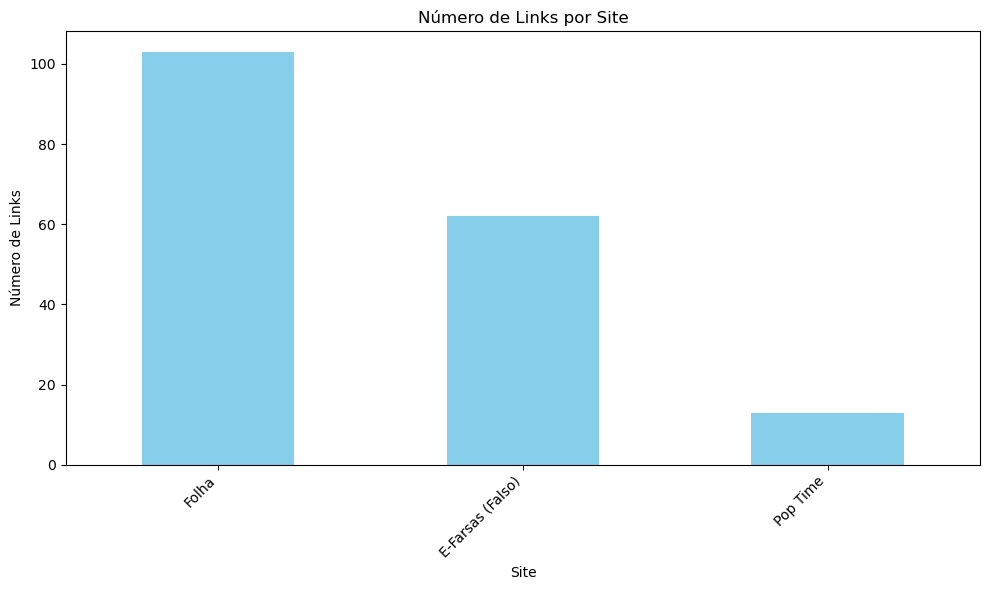

In [62]:
# Contar o número de links para cada site
site_counts = df_combinedfake['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

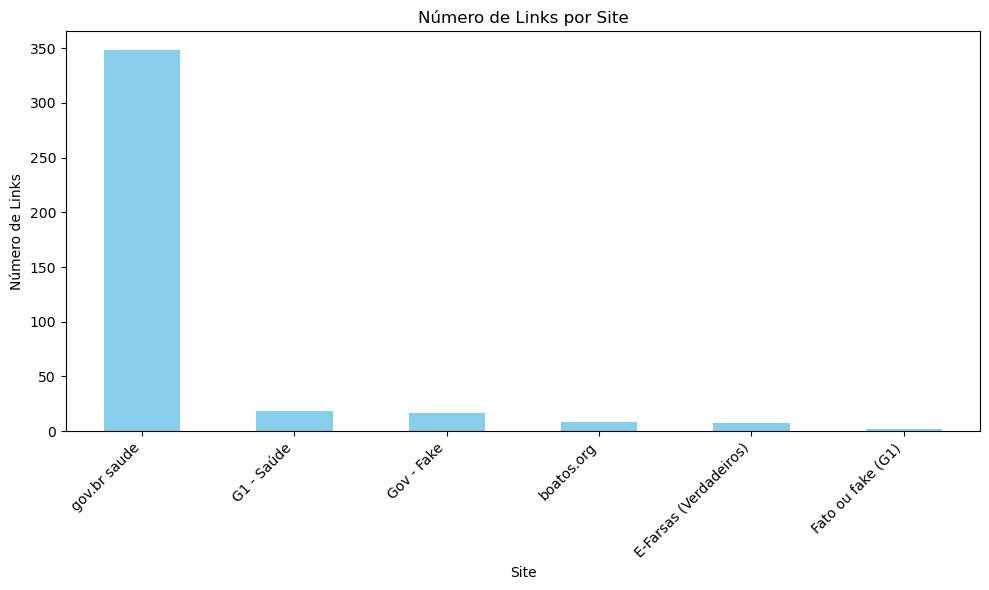

In [63]:
# Contar o número de links para cada site
site_counts = df_combinedtrue['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

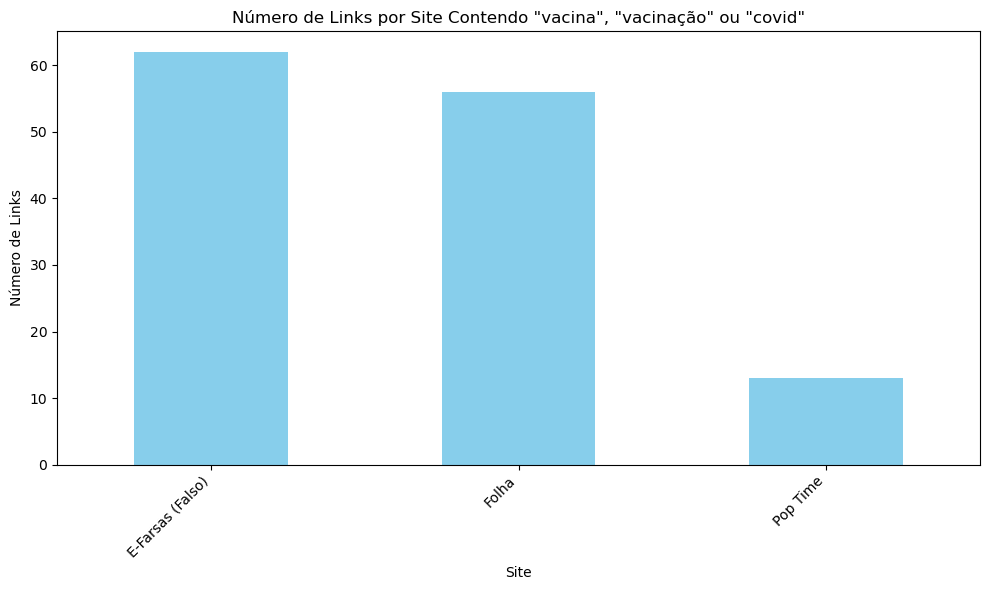

In [64]:
# Filtrar os links que contêm as palavras-chave
filtered_df = df_combinedfake[df_combinedfake['title'].str.contains('|'.join(keywords), case=False, na=False)]

# Contar o número de links para cada site
site_counts = filtered_df['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site Contendo "vacina", "vacinação" ou "covid"')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

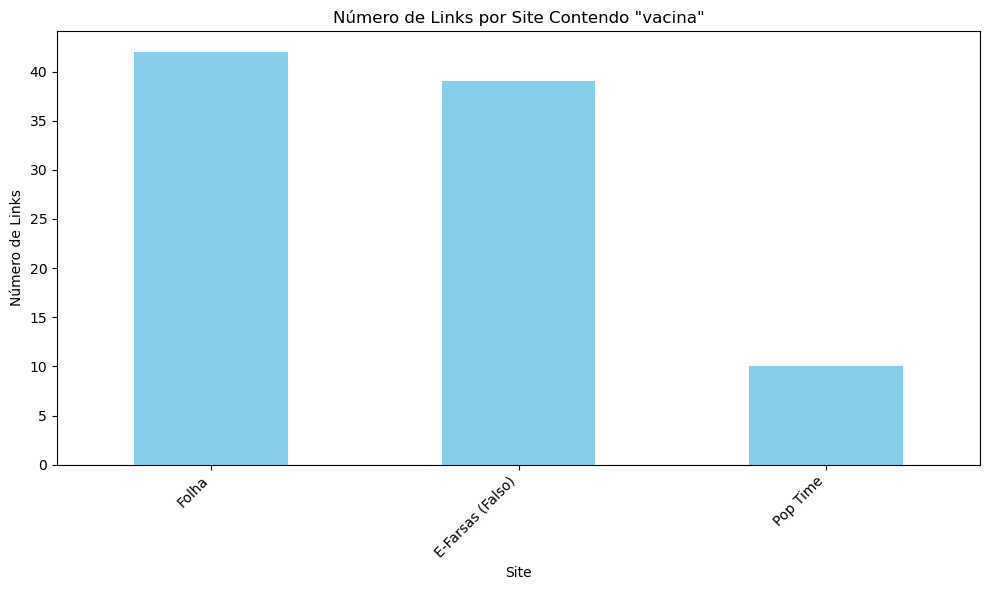

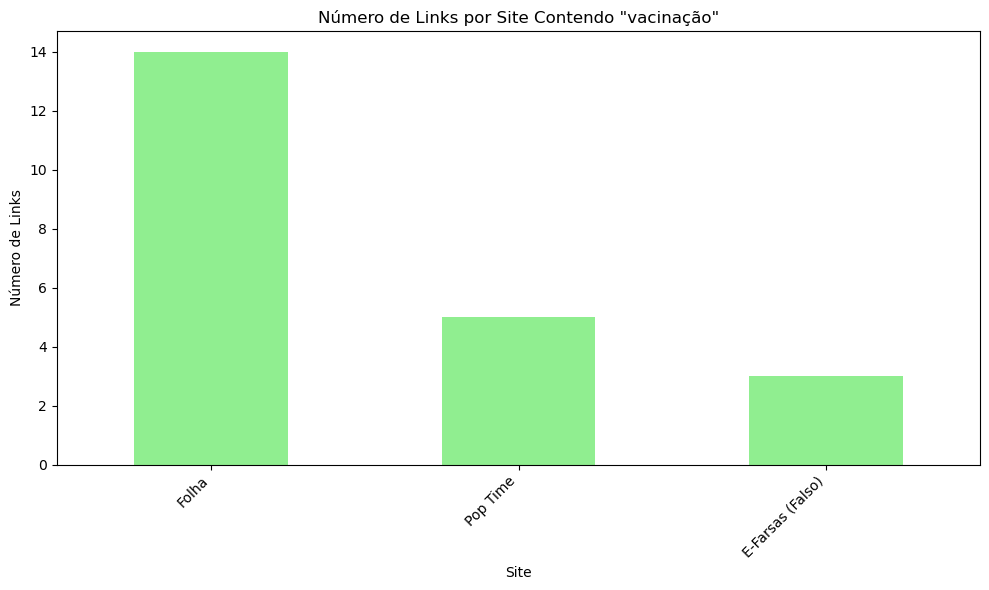

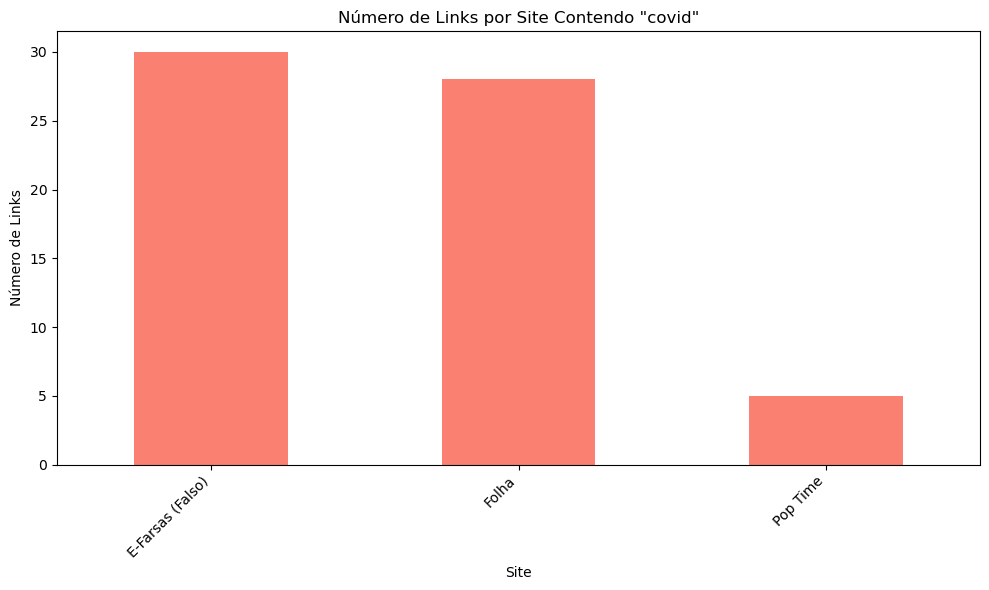

In [65]:
# Gráfico para "vacina"
plot_keyword_distribution(df_combinedfake, "vacina", 'skyblue')

# Gráfico para "vacinação"
plot_keyword_distribution(df_combinedfake, "vacinação", 'lightgreen')

# Gráfico para "covid"
plot_keyword_distribution(df_combinedfake, "covid", 'salmon')

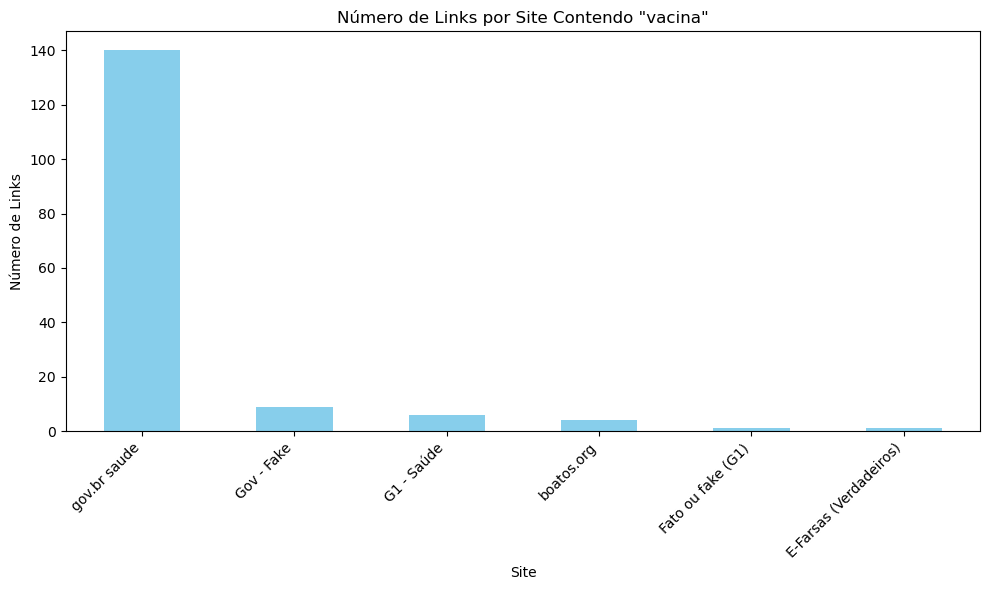

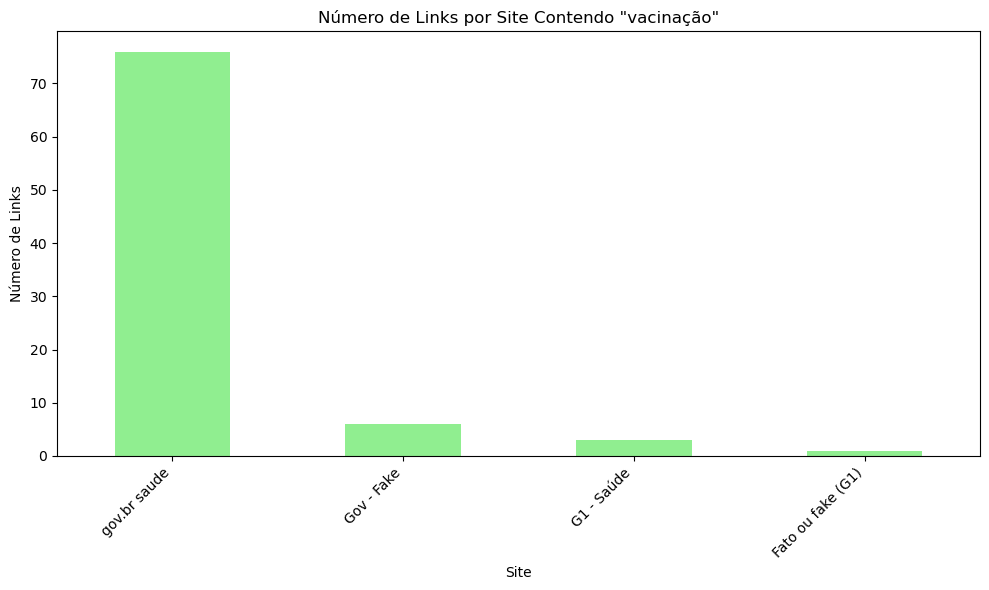

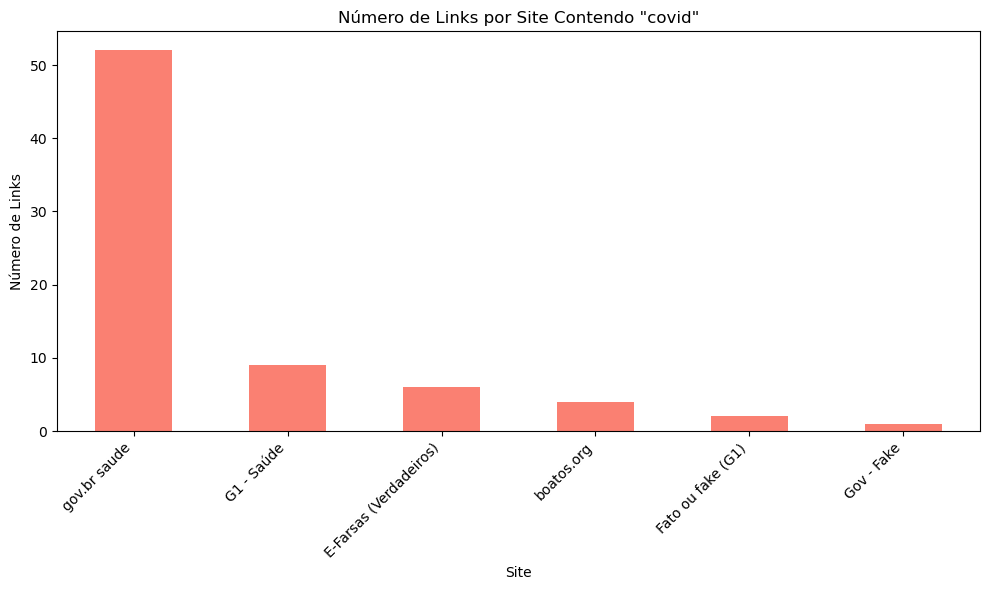

In [66]:
# Gráfico para "vacina"
plot_keyword_distribution(df_combinedtrue, "vacina", 'skyblue')

# Gráfico para "vacinação"
plot_keyword_distribution(df_combinedtrue, "vacinação", 'lightgreen')

# Gráfico para "covid"
plot_keyword_distribution(df_combinedtrue, "covid", 'salmon')

In [105]:
# Certifique-se de ter baixado as stopwords
nltk.download('stopwords')

# Lista de stopwords em português
stop_words = set(stopwords.words('portuguese'))

def process_links_column(df):
    # Função para processar cada link
    def split_and_clean(link):
        # Dividir o link por '/', '-', '%', '.', e ':'
        words = re.split(r'[/\-\%\.\:]', link)
        # Remover palavras indesejadas, stopwords e letras isoladas, mantendo acentos
        unwanted = {'https', 'gov', 'www', 'com', 'br', 'pt'}
        cleaned_words = [
            word for word in words 
            if word.lower() not in stop_words 
            and not any(unwanted_word in word.lower() for unwanted_word in unwanted) 
            and len(word) > 1
        ]
        return cleaned_words
    
    # Aplicar a função a cada link na coluna 'links'
    df['processed_links'] = df['link'].apply(split_and_clean)
    return df

# Aplicar ao dataframe df_combinedtrue
df_combinedtrue = process_links_column(df_combinedtrue)

# Visualizar o resultado
df_combinedtrue[['link', 'processed_links']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ABTLUS/pedro220058/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,link,processed_links
0,https://g1.globo.com/fato-ou-fake/campinas-e-r...,"[g1, globo, fato, fake, campinas, regiao, noti..."
1,https://g1.globo.com/fato-ou-fake/noticia/2024...,"[g1, globo, fato, fake, noticia, 2024, 07, 03,..."
2,https://www.gov.br/saude/pt-br/assuntos/covid-19,"[saude, assuntos, covid, 19]"
3,https://www.gov.br/saude/pt-br/vacinacao,"[saude, vacinacao]"
4,https://www.gov.br/saude/pt-br/vacinacao/calen...,"[saude, vacinacao, calendario]"
...,...,...
395,https://www.gov.br/saude/pt-br/vacinacao/manuais,"[saude, vacinacao, manuais]"
396,https://www.gov.br/saude/pt-br/vacinacao/legis...,"[saude, vacinacao, legislacao]"
397,https://www.gov.br/saude/pt-br/vacinacao/publi...,"[saude, vacinacao, publicacoes]"
398,https://infoms.saude.gov.br/extensions/SEIDIGI...,"[infoms, saude, extensions, SEIDIGI_DEMAS_VACI..."


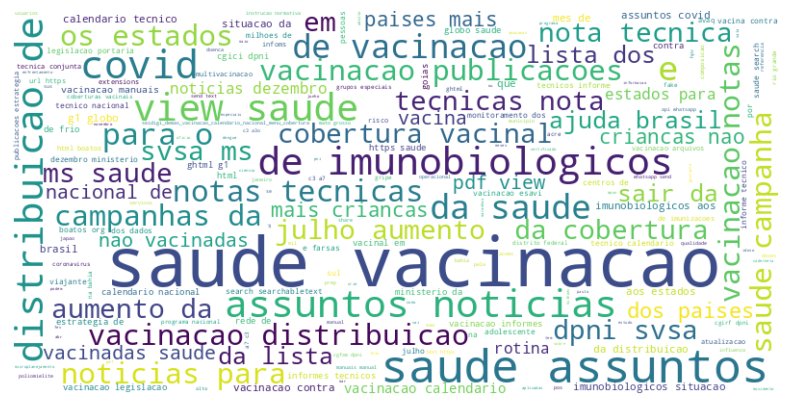

In [107]:
# Função para remover as strings indesejadas
def clean_link_text(link):
    # Separar as palavras por '/', '-', '%', '.', e ':'
    words = re.split(r'[/\-\%\.\:]', link)
    # Lista de palavras indesejadas para remover
    unwanted_words = {'https', 'com', 'br', 'pt', 'https:', 'www', 'gov'}
    # Filtrar as palavras, removendo as indesejadas
    cleaned_words = [word.lower() for word in words if word.lower() not in unwanted_words]
    return ' '.join(cleaned_words)

# Aplicar a função de limpeza nos links
df_combinedtrue['cleaned_links'] = df_combinedtrue['link'].apply(clean_link_text)

# Unir todos os links limpos em um único texto
text = ' '.join(df_combinedtrue['cleaned_links'])

# Remover quaisquer instâncias restantes de "gov" e "br" após a junção das palavras
unwanted_patterns = re.compile(r'\b(gov|br)\b', re.IGNORECASE)
text = unwanted_patterns.sub('', text)

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()